[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)

based on [Rozanski & Sonntag 1982](https://doi.org/10.3402/tellusa.v34i2.10795)

**TODO #1207**:
- Fig. 6
- asserts for T step
- asserts for T final
- switch to the same fractionation formulae as used in the paper
- move eq. 2 to formulae
- smoke tests

In [1]:
import os
os.environ['NUMBA_DISABLE_JIT']='1'
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot, ticker
from PySDM.physics import si, in_unit
from PySDM import Formulae, Builder, products, dynamics
from PySDM.environments import Parcel
from PySDM.backends import CPU
from PySDM.products.impl.moist_environment_product import MoistEnvironmentProduct
from PySDM_examples.utils import BasicSimulation
import numpy as np

In [18]:
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line_excess='Dansgaard1964',
    isotope_ratio_evolution='MerlivatAndJouzel1979',
)
const = formulae.constants
trivia = formulae.trivia

FIG4_CAPTION_PARAMS = {
    'T_init': const.T0 + 25 * si.K,
    'T_fini': const.T0 - 10 * si.K,
    'T_step': 2 * si.K,
    'P_init': 1000 * si.mbar,
    'RH_init': 80 * const.PER_CENT,
    'delta_2H_init': -74.7 * const.PER_MILLE,  # note: R0 in the caption, but negative, hence delta
    'isotope_exchange_factor': 1,  # the "K" parameter
    'autoconversion_mixrat_threshold': 1 * si.g / si.m**3 / (1 * si.kg / si.m**3) # the "N_L" parameter, note: mixing ratio in the caption, but per-volume units, hence density
}
ARBITRARY_PARAMS = {
    'N_SUPER_DROPLETS': 1,
    'N_OUTPUT_INTERVALS': 71,
    'N_ITERATIONS': 61,
    'TIMESTEP': 100 * si.s,
    'PARCEL_MASS_OF_DRY_AIR': 1 * si.kg,
    'PARCEL_VERTICAL_VELOCITY': 1 * si.m / si.s,
    'PARCEL_MONODISPERSE_DRY_AEROSOL_RADIUS': .1 * si.um,
    'PARCEL_MONODISPERSE_DRY_AEROSOL_NUMBER': (1000 / si.cm**3) * si.m**3,
    'KAPPA': 1,
}
assert (ARBITRARY_PARAMS['N_ITERATIONS']-1) % 4 == 0

In [19]:
def Rv_prim(*, Rl, Nl, Rv, Nv, dNl, Rr, K, a):
    return (
        Rl * Nl + Rv * Nv + dNl * Rr * K
    ) / (
        (Nl + dNl * K) * a + Nv
    )

class MultiBox(Parcel):
    def __init__(self, *, delta_nl, rain_isotope_ratio, **kwargs):
        super().__init__(variables=["Rv_2H", "Rr_2H"], **kwargs)
        self.delta_nl = delta_nl
        self.rain_isotope_ratio = rain_isotope_ratio
    
    def advance_parcel_vars(self):
        """ explicit Euler integration of isotope-ration derivative """
        self._recalculate_temperature_pressure_relative_humidity(self._tmp)
        
        alpha_old = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(self["T"][0])
        alpha_new = formulae.isotope_equilibrium_fractionation_factors.alpha_l_2H(self._tmp["T"][0])
        
        dRv_2H__dt = self['Rv_2H'][0] * self.formulae.isotope_ratio_evolution.d_Rv_over_Rv(
            alpha=alpha_old,
            d_alpha=(alpha_new - alpha_old) / self.dt,
            n_vapour=self['water_vapour_mixing_ratio'][0],
            d_n_vapour=-self.delta_liquid_water_mixing_ratio / self.dt,
            n_liquid=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold']  # TODO #1207
        )
        
        super().advance_parcel_vars()
        self.particulator.backend.explicit_euler(self._tmp["Rv_2H"], self.particulator.dt, dRv_2H__dt)

        level = self.particulator.n_steps
        if self.delta_nl is not None:
            self._tmp["Rv_2H"][:] = Rv_prim(
                Rl=alpha_old * self._tmp['Rv_2H'][0],
                Nl=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'],
                Rv=self._tmp['Rv_2H'][0],
                Nv=self['water_vapour_mixing_ratio'][0],
                dNl=np.sum(self.delta_nl[level:]),
                Rr=.995 * self.rain_isotope_ratio[min(level+1, ARBITRARY_PARAMS['N_OUTPUT_INTERVALS'])],  # TODO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                K=FIG4_CAPTION_PARAMS["isotope_exchange_factor"],
                a=alpha_old
            )
        self._tmp["Rr_2H"][:] = alpha_old * self._tmp["Rv_2H"][0]

class AmbientIsotopicRatio(MoistEnvironmentProduct):
    def __init__(self, name=None, unit="dimensionless", var=None):
        super().__init__(name=name, unit=unit, var=var)

In [20]:
class Simulation(BasicSimulation):
    def __init__(self, *, delta_nl, rain_isotope_ratio):
        env = MultiBox(
            p0=FIG4_CAPTION_PARAMS['P_init'],
            initial_water_vapour_mixing_ratio=const.eps / (
                FIG4_CAPTION_PARAMS['P_init']
                / FIG4_CAPTION_PARAMS['RH_init']
                / formulae.saturation_vapour_pressure.pvs_Celsius(FIG4_CAPTION_PARAMS['T_init'] - const.T0)
                - 1
            ),
            T0=FIG4_CAPTION_PARAMS['T_init'],
            w=ARBITRARY_PARAMS['PARCEL_VERTICAL_VELOCITY'],
            mass_of_dry_air=ARBITRARY_PARAMS['PARCEL_MASS_OF_DRY_AIR'],
            dt=ARBITRARY_PARAMS['TIMESTEP'],
            delta_nl=delta_nl,
            rain_isotope_ratio=rain_isotope_ratio,
        )
        builder = Builder(n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'], backend=CPU(formulae), environment=env)
        builder.add_dynamic(dynamics.AmbientThermodynamics())
        builder.add_dynamic(dynamics.Condensation())
        attributes = env.init_attributes(
            kappa = ARBITRARY_PARAMS['KAPPA'],
            r_dry = ARBITRARY_PARAMS['PARCEL_MONODISPERSE_DRY_AEROSOL_RADIUS'],
            n_in_dv = ARBITRARY_PARAMS['PARCEL_MONODISPERSE_DRY_AEROSOL_NUMBER']
        )

        env["Rv_2H"][:] = formulae.trivia.isotopic_delta_2_ratio(
            delta=FIG4_CAPTION_PARAMS['delta_2H_init'],
            reference_ratio=const.VSMOW_R_2H
        )
        
        super().__init__(particulator = builder.build(
            attributes=attributes,
            products=(
                products.AmbientTemperature(var='T', name='T'),
                products.AmbientRelativeHumidity(var='RH', name="RH"),
                products.AmbientWaterVapourMixingRatio(var='water_vapour_mixing_ratio', name='QV'),
                products.WaterMixingRatio(name='QL'),
                AmbientIsotopicRatio(name='Rv_2H', var="Rv_2H"),
                AmbientIsotopicRatio(name='Rr_2H', var="Rr_2H")
            )
        ))

In [21]:
delta_nl = None
rain_isotope_ratio = None
output = []
level_indices = {}

for iteration in range(ARBITRARY_PARAMS['N_ITERATIONS']):
    print(f"{iteration=}")
    simulation = Simulation(
        delta_nl=delta_nl,
        rain_isotope_ratio=rain_isotope_ratio,
    )
    tmp = simulation._run(
        nt=ARBITRARY_PARAMS['N_OUTPUT_INTERVALS'] ,
        steps_per_output_interval=1
    )
    for k, v in tmp.items():
        tmp[k] = np.asarray(v)
    rain_isotope_ratio = tmp['Rr_2H']
    if iteration == 0:
        tmp['QR'] = np.maximum(0, tmp['QL'] - FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
        tmp['QL'] = np.minimum(tmp['QL'], FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
        delta_nl = np.diff(np.concatenate(([0], tmp['QR']))) # TODO: per delta-T (which is not constant!!!)
        level_indices['CB'] = np.argmin(tmp['RH'] < 1)
        level_indices['FRL'] = np.amin(np.argmax(tmp['QL']))
    output.append(tmp)

iteration=0
iteration=1
iteration=2
iteration=3
iteration=4
iteration=5
iteration=6
iteration=7
iteration=8
iteration=9
iteration=10
iteration=11
iteration=12
iteration=13
iteration=14
iteration=15
iteration=16
iteration=17
iteration=18
iteration=19
iteration=20
iteration=21
iteration=22
iteration=23
iteration=24
iteration=25
iteration=26
iteration=27
iteration=28
iteration=29
iteration=30
iteration=31
iteration=32
iteration=33
iteration=34
iteration=35
iteration=36
iteration=37
iteration=38
iteration=39
iteration=40
iteration=41
iteration=42
iteration=43
iteration=44
iteration=45
iteration=46
iteration=47
iteration=48
iteration=49
iteration=50
iteration=51
iteration=52
iteration=53
iteration=54
iteration=55
iteration=56
iteration=57
iteration=58
iteration=59
iteration=60


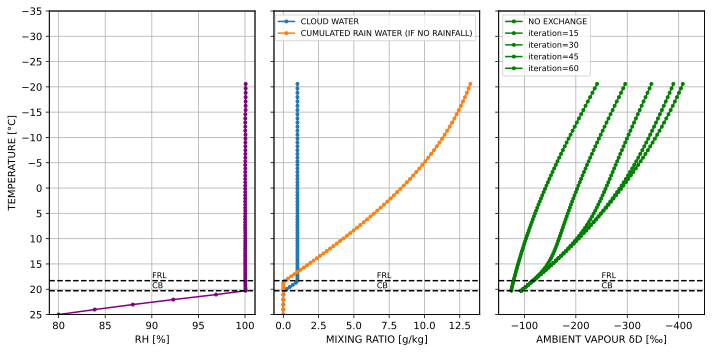

HTML(value="<a href='./fig_4.pdf' target='_blank'>./fig_4.pdf</a><br>")

In [30]:
temp_C = output[0]["T"] - const.T0

fig, axs = pyplot.subplots(1, 3, squeeze=False, sharey=True, figsize=(10,5), tight_layout=True)

axs[0,0].set_ylabel('TEMPERATURE [°C]')
axs[0,0].set_ylim(25, -35)
axs[0,0].yaxis.set_major_locator(ticker.MultipleLocator(5))

axs[0,0].plot(
    output[0]['RH'] / const.PER_CENT,
    temp_C,
    marker='.',
    color='purple'
)
axs[0,0].set_xlabel('RH [%]')
axs[0,0].grid()

axs[0,1].plot(
    in_unit(output[0]['QL'], si.g / si.kg),
    temp_C,
    marker='.',
    label='CLOUD WATER'
)
axs[0,1].plot(
    in_unit(output[0]['QR'], si.g / si.kg),
    temp_C,
    marker='.',
    label='CUMULATED RAIN WATER (IF NO RAINFALL)'
)
axs[0,1].set_xlabel('MIXING RATIO [g/kg]')
axs[0,1].grid()
axs[0,1].legend(fontsize=8)

for iteration in range(0, ARBITRARY_PARAMS['N_ITERATIONS'], (ARBITRARY_PARAMS['N_ITERATIONS']-1) // 4):
    axs[0,2].plot(
        in_unit(formulae.trivia.isotopic_ratio_2_delta(
            ratio=output[iteration]['Rv_2H'][level_indices['CB']:],
            reference_ratio=const.VSMOW_R_2H
        ), const.PER_MILLE),
        temp_C[level_indices['CB']:],
        marker='.',
        color='green',
        label=('NO EXCHANGE' if iteration == 0 else f"{iteration=}")
    )
axs[0,2].set_xlabel('AMBIENT VAPOUR δD [‰]')
axs[0,2].set_xlim(-50, -450)
axs[0,2].grid()
axs[0,2].legend(loc="upper left", fontsize=8)

for ax in axs.squeeze():
    twinx = ax.twiny()
    twinx.set_xlim(0,1)
    twinx.set_xticks([])
    for label, level_index in level_indices.items():
        twinx.plot([0, 1], [temp_C[level_index]]*2, color='black', linestyle='--')
        twinx.text(.5, temp_C[level_index] - .5, label, fontsize=8)

show_plot('fig_4.pdf')

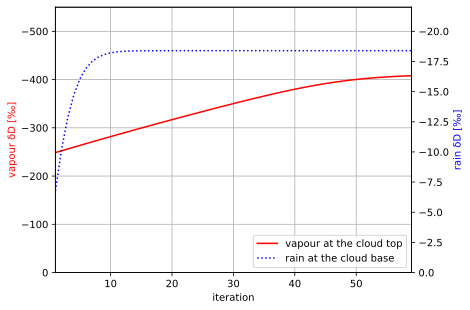

HTML(value="<a href='./fig_5.pdf' target='_blank'>./fig_5.pdf</a><br>")

In [29]:
data = {
    lev: {
        k: np.asarray([
            output[i][k][lev]
            for i in range(ARBITRARY_PARAMS['N_ITERATIONS'])
        ])
        for k in ('Rv_2H', 'Rr_2H')
    }
    for lev in (-1, level_indices['CB'])
}

colors = {'vapour': 'red', 'rain': 'blue'}

lines = []
lines.append(*pyplot.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data[-1]["Rv_2H"][1:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="vapour at the cloud top",
    color=colors['vapour']
))
pyplot.ylim(0, -550)
pyplot.ylabel('vapour δD [‰]', color=colors['vapour'])

pyplot.xlim(1, ARBITRARY_PARAMS['N_ITERATIONS']-2)
pyplot.xlabel('iteration')
pyplot.grid()

twinx = pyplot.gca().twinx()
twinx.set_ylim(0, -22)
twinx.set_ylabel('rain δD [‰]', color=colors['rain'])
lines.append(*twinx.plot(
    in_unit(formulae.trivia.isotopic_ratio_2_delta(
        ratio=data[level_indices['CB']]["Rr_2H"][1:],
        reference_ratio=const.VSMOW_R_2H
    ), const.PER_MILLE),
    label="rain at the cloud base",
    color=colors['rain'],
    linestyle=':'
))
pyplot.legend(lines, [l.get_label() for l in lines], loc='lower right')
show_plot('fig_5.pdf')